**Outstanding**
- Finish writing the function documentations
- Decide which k-fibers/cells to throw
- Need comments on k-fiber tracking
- Force_PP inferenc / single-parameter inferences (as controls)
- Test whether giving some wiggle room to the kinetochore end
  would change the parameters noticeably

- Side-by-side comparison of the three fitting strategies to illustrate\
  that the M0, Rx version is significantly better
  
  
- remove 20171215_cell005 0 and 20180628_cell002 1, retrack 20210526_cell001 1 and 20171215_cell005 1 )

In [35]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from brokenaxes import brokenaxes

import scipy.optimize
import scipy.signal
from scipy import interpolate

import numba

import pandas as pd
import matplotlib.image as mpimg
import glob
import re

from tqdm.notebook import tqdm

import corner
import emcee

import sys
sys.path.append('../')
from functions import *

In [36]:
@numba.njit
def deflection_small_angle(param, x, L, Rx_zero=False, Ry_zero=False):
    """
    Calculates the deflection profile using the analytic
    results obtained with the small angle approximation.
    
    The two endpoints of the profile are at (0,0) and (L,0).
    
    Parameters
    ----------
    param : array_like
        Mechanical parameters at the pole.
        
        If the moment at the kinetochore is nonzero,
        the variable `param` unpacks into (M0, Rx, Ry).
        
        If the moment at the kinetochore is zero, then
        specifying Ry would set the value of M0 and vice versa.
        Therefore, the varaible `param` unpacks into the pair
        of values (Rx, Ry).
        
    x : float or numpy array
        Positions where the deflection is evaluated.
        
    L : float
        End-to-end distance of the curved beam.
        
    Rx_zero : boolean
        If True, the Rx value is set to zero, irrespective of the input value.
        
    Ry_zero : boolean
        If True, the Ry value is set to zero, irrespective of the input value.
        
    
    Returns
    -------
    y : float or numpy array
        Deflection amounts at positions `x`.
    """
            
    # Unpack the parameters
    if len(param) == 2: # Mk=0 case
        Rx, Ry = param
        M0 = Ry*L
    elif len(param) == 3: #Mk≠0 case
        Rx, M0, Ry = param
        
    if Rx_zero:
        Rx = 0
        
    if Ry_zero:
        Ry = 1e-6
        M0 = Ry*L

    
    if Rx == 0:
        y = L/2*(M0 - Ry*L/3)*x - M0/2*x**2 + Ry/6*x**3
    elif Rx < 0.0:
        k = np.sqrt(-Rx)
        y_part1 = Ry/Rx*(x-L*np.sinh(k*x)/np.sinh(k*L))
        y_part2 = -M0/Rx*((1-np.exp(-k*x)) - (1-np.exp(-k*L))*np.sinh(k*x)/np.sinh(k*L))
        y = y_part1 + y_part2
    else:
        k = np.sqrt(Rx)
        y = M0/Rx*np.cos(k*x) + (M0/Rx*(1-np.cos(k*L)) - Ry/Rx*L)/np.sin(k*L)*np.sin(k*x) + Ry/Rx*x - M0/Rx
        
    return y

def residual_small_angle(param, x_dat, y_dat, L, Rx_zero=False, Ry_zero=False, n_dense = 500):
    """
    Calculates the differences between the measured deflection
    values and those predicted by the analytical model with 
    specified parameters `param`.

    Parameters
    ----------
    param : array_like
        Mechanical parameters at the pole.
    
    x_dat : float or numpy array
        Measured x-positions of a k-fiber profile.
    
    y_dat : float or numpy array
        Measured y-positions of a k-fiber profile.
    
    L : float
        End-to-end distance of the curved beam.
    
    Rx_zero : boolean
        If True, the Rx value is set to zero, irrespective of the input value.
        
    Ry_zero : boolean
        If True, the Ry value is set to zero, irrespective of the input value.
        
        
    Returns
    -------
    res : float or numpy array
        Difference between measured and predicted deflection values.
    """
    
    # Deflection values predicted by the model
    y_mod = deflection_small_angle(param, x_dat, L, Rx_zero, Ry_zero)
    
    # Predicted profile with a higher resolution
    f = interpolate.interp1d(x_dat, y_mod)
    x_dense = np.linspace(x_dat.min(), x_dat.max(), n_dense)
    y_dense = f(x_dense)
    
    res, _ = distances_pair_min(x_dat, y_dat, x_dense, y_dense)
    
    return res

In [37]:
@numba.njit
def deflection_exact(param, x_dat, y_dat, L, rot_angle, n_div=100, length_conserved=True, \
                     Rx_zero=False, Ry_zero=False, force_PP=False, method='midpoint'):
    """
    Calculates the deflection profile of the k-fiber
    using the exact nonlinear expression of curvature 
    in the Euler-Bernoulli equation.
    
    Parameters
    ----------
    param : array_like
        Mechanical parameters at the pole, along with the starting k-fiber
        angle relative to the pole-kinetochore axis.
        
    x_dat : float or numpy array
        Measured x-positions of a k-fiber profile.
    
    y_dat : float or numpy array
        Measured y-positions of a k-fiber profile.
        
    L : float
        End-to-end distance of the curved beam.
        
    rot_angle : float
        Angle that the pole-kinetochore axis forms with the pole-pole axis.
        
    n_div : int
        Number of small divisions in the generated k-fiber profile in the
        `length_conserved=True` case. When `length_conserved=False`, up to
        4 times more divisions are allowed.
        
    length_conserved : boolean
        If True, the k-fiber profile is generated up to the point where
        its contour length matches that of the measured profiles.
        If False, the k-fiber profile generation stops when the rightmost
        position reaches x=L, where L is the end-to-end distance of the
        measured k-fiber profile.
        
    method : string
        If 'midpoint', a more accurate integration method is used for profile
        generation.
        If 'Euler', the simpler but less accurate Euler integration is used.
        
    Rx_zero : boolean
        If True, the Rx value is set to zero, irrespective of the input value.
        
    Ry_zero : boolean
        If True, the Ry value is set to zero, irrespective of the input value.
        
    force_PP : boolean
        If True, the Ry value is set in a way that makes the total force at the 
        pole point along the pole-pole (PP) axis.
    
    
    Returns
    -------
    x_output : numpy array
        x-positions of the predicted profile that match with the x-positions of the data.
        
    y_output : numpy array
        y-positions of the predicted profile corresponding to `x_output`.
        
    x_ls : numpy array
        x-positions of the predicted profile with a resolution defined via `n_div`.
        
    y_ls : numpy array
        y-positions of the predicted profile with a resolution defined via `n_div`.
    """
    
    # Unpack the parameters
    if len(param) == 3: # Mk=0 case
        Rx, Ry, theta0 = param
        M0 = Ry*L
    elif len(param) == 4: #Mk≠0 case
        Rx, M0, Ry, theta0 = param
    
    
    if Rx_zero:
        Rx = 0
    if Ry_zero:
        Ry = 0
        M0 = 0
        
    
    if force_PP:
        Ry = -np.tan(rot_angle)*Rx
        
    
    s_dat_ls, L_contour = contour_fn(x_dat, y_dat)    
    ds = L_contour/n_div
    if length_conserved:
        n_steps = n_div+2
    else:
        n_steps = int(1.5*n_div)
    
    
    theta_ls = np.zeros(n_steps)
    theta_ls[0] = theta0
    
    x_ls = np.zeros(n_steps)
    y_ls = np.zeros(n_steps)

    if method=='midpoint':
        for i in range(1,n_steps):
            M = M0 + Rx*y_ls[i-1] - Ry*x_ls[i-1]
            theta_mid = theta_ls[i-1] - ds/2*M
            y_mid = y_ls[i-1] + ds/2*np.sin(theta_mid)
            x_mid = x_ls[i-1] + ds/2*np.cos(theta_mid)
            
            M_mid = M0 + Rx*y_mid - Ry*x_mid
            theta_ls[i] = theta_ls[i-1] - ds*M_mid
            x_ls[i] = x_ls[i-1] + ds*np.cos(theta_mid)
            y_ls[i] = y_ls[i-1] + ds*np.sin(theta_mid)
                    
    elif method=='euler':
        for i in range(1,n_steps):
            x_ls[i] = x_ls[i-1] + ds*np.cos(theta_ls[i-1])
            y_ls[i] = y_ls[i-1] + ds*np.sin(theta_ls[i-1])

            M = M0 + Rx*y_ls[i-1] - Ry*x_ls[i-1]
            theta_ls[i] = theta_ls[i-1] - ds*M
            
    else:
        raise ValueError('Incorrect method specified.')
    
    return x_ls, y_ls

    
def res_fn_exact(param, x_dat, y_dat, L, rot_angle, length_conserved=True, end_match=False, \
                 Rx_zero=False, Ry_zero=False, force_PP=False, n_dense=300):
    
    x_mod, y_mod = deflection_exact(param, x_dat, y_dat, L, rot_angle, length_conserved=length_conserved, \
                                    Rx_zero=Rx_zero, Ry_zero=Ry_zero, force_PP=force_PP)
    
    f = interpolate.interp1d(x_mod, y_mod)
    x_dense = np.linspace(x_mod.min(), x_mod.max(), n_dense)
    y_dense = f(x_dense)
    
    res, _ = distances_pair_min(x_dat, y_dat, x_dense, y_dense)
    
    if end_match:
        end_penalty = np.max([res[-1]/L, 0.02/L])
        res *= end_penalty
        
    return res

In [38]:
def logpost_exact(param, x_dat, y_dat, L, rot_angle, length_conserved=True, end_match=False, \
                  Rx_zero=False, Ry_zero=False, force_PP=False):
    
    # Unpack the parameters
    if len(param) == 3: # Mk=0 case
        Rx, Ry, theta0 = param
        M0 = Ry*L
    elif len(param) == 4: #Mk≠0 case
        Rx, M0, Ry, theta0 = param

    Mk = M0 - (Ry*L)
    
    if Mk < 0:
        return -np.inf

    if M0 < 0:
        return -np.inf
    
    if Rx > 2:
        return -np.inf
    
    res = res_fn_exact(param, x_dat, y_dat, L, PP_K_angle, length_conserved=length_conserved, \
                       end_match=end_match, Rx_zero=Rx_zero, Ry_zero=Ry_zero, force_PP=force_PP)
    return -5*np.log(np.sqrt(np.sum(res**2)))

20171215_cell004 0
pole_left
P-K distance (L) =  6.39 um
Initial angle =  10.26 degrees
number of evaluations = 538


100%|██████████| 200/200 [00:00<00:00, 207.93it/s]


0.0428034925199251 0.08152707446922368 0.010835317114595788 0.012319819887936054
res_mcmc: 0.017693
Exact method error (gradient): 0.0202
Exact method error (mcmc): 0.0202
Small-angle error: 0.0049


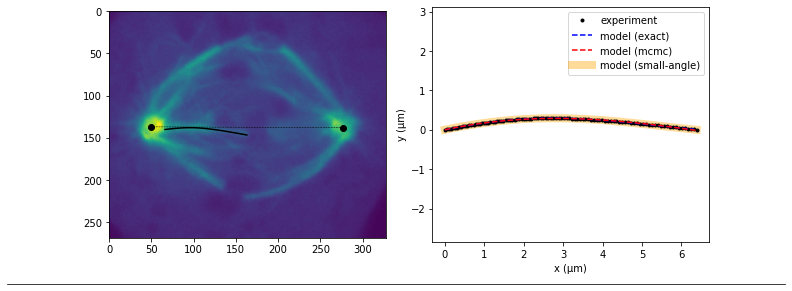

20171215_cell004 1
pole_right
P-K distance (L) =  6.69 um
Initial angle =  4.86 degrees
number of evaluations = 2003


100%|██████████| 200/200 [00:00<00:00, 201.85it/s]


0.2007575513745721 0.0019446829757834936 -0.00026659422808232667 0.003728831863527157
res_mcmc: 0.000703
Exact method error (gradient): 0.0223
Exact method error (mcmc): 0.0215
Small-angle error: 0.0038


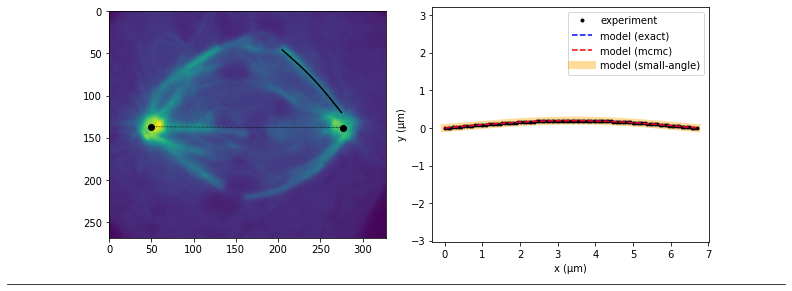

20171215_cell004 2
pole_right
P-K distance (L) =  8.38 um
Initial angle =  22.45 degrees


  0%|          | 0/200 [00:00<?, ?it/s]

number of evaluations = 279


100%|██████████| 200/200 [00:01<00:00, 198.01it/s]


0.09337834745627101 0.05585650777363321 0.005467193399091943 0.010034166051748429
res_mcmc: 0.018519
Exact method error (gradient): 0.0296
Exact method error (mcmc): 0.0300
Small-angle error: 0.3379


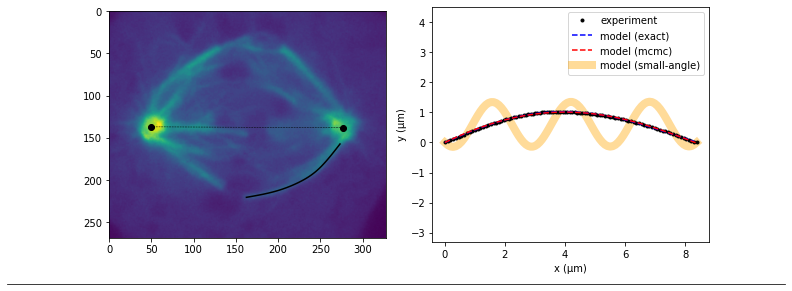

20171215_cell004 3
pole_right
P-K distance (L) =  8.35 um
Initial angle =  28.00 degrees


 10%|▉         | 19/200 [00:00<00:00, 183.23it/s]

number of evaluations = 1433


100%|██████████| 200/200 [00:00<00:00, 208.43it/s]


0.07115735593584549 0.09539234671362237 0.010010430829266913 0.011810661244217341
res_mcmc: 0.003034
Exact method error (gradient): 0.0239
Exact method error (mcmc): 0.0240
Small-angle error: 0.0073


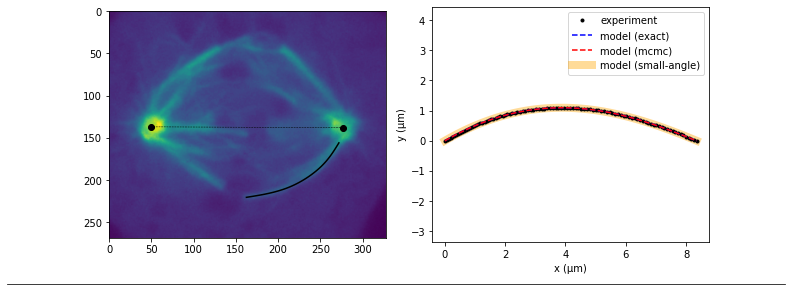

20171215_cell004a 0
pole_left
P-K distance (L) =  8.23 um
Initial angle =  21.61 degrees


  9%|▉         | 18/200 [00:00<00:01, 179.30it/s]

number of evaluations = 941


100%|██████████| 200/200 [00:00<00:00, 206.01it/s]


0.030184750087411585 0.11933874912609226 0.010893974095223073 0.029700375274815477
res_mcmc: 0.008315
Exact method error (gradient): 0.0246
Exact method error (mcmc): 0.0245
Small-angle error: 0.0094


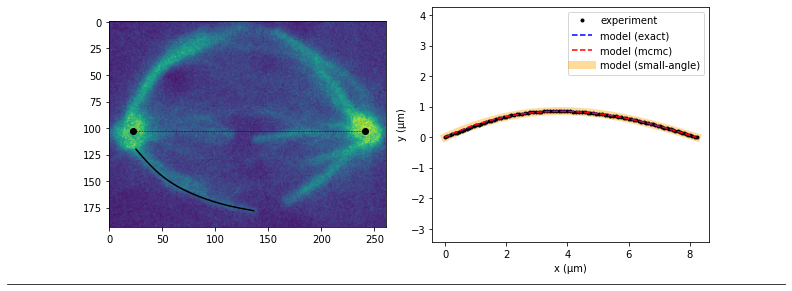

20171215_cell004a 1
pole_right
P-K distance (L) =  5.78 um
Initial angle =  5.82 degrees
number of evaluations = 646


100%|██████████| 200/200 [00:00<00:00, 218.68it/s]


0.1706261535511743 0.03271103650329618 0.005598327478448583 0.00038033906728573985
res_mcmc: 0.002909
Exact method error (gradient): 0.0192
Exact method error (mcmc): 0.0185
Small-angle error: 0.0036


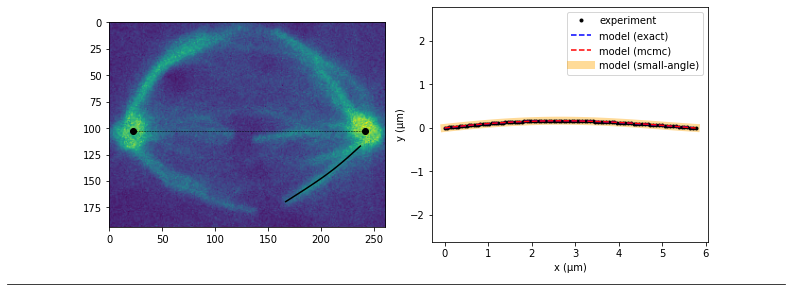

20171215_cell005 0
pole_left
P-K distance (L) =  6.22 um
Initial angle =  25.90 degrees


 10%|█         | 20/200 [00:00<00:00, 191.82it/s]

number of evaluations = 307


100%|██████████| 200/200 [00:00<00:00, 220.89it/s]


0.12533281960853193 0.13862109626951336 0.022172586482752034 0.0007220342992343143
res_mcmc: 0.015010
Exact method error (gradient): 0.0229
Exact method error (mcmc): 0.0251
Small-angle error: 0.0095


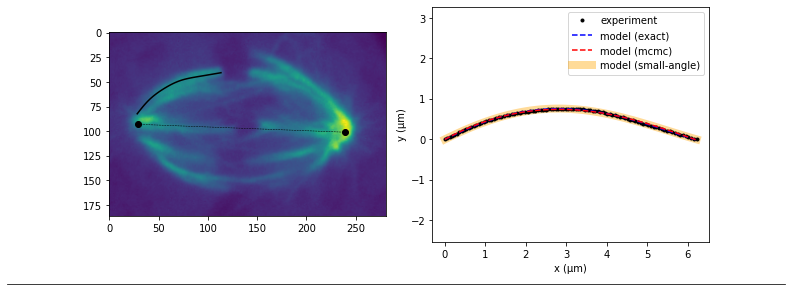

20171215_cell005 1
pole_right
P-K distance (L) =  7.42 um
Initial angle =  17.45 degrees


 10%|█         | 20/200 [00:00<00:00, 190.31it/s]

number of evaluations = 1068


100%|██████████| 200/200 [00:00<00:00, 202.47it/s]


0.009889246551292925 0.1040458862873742 0.004495214680325623 0.07070434080321059
res_mcmc: 0.009936
Exact method error (gradient): 0.0205
Exact method error (mcmc): 0.0210
Small-angle error: 0.0090


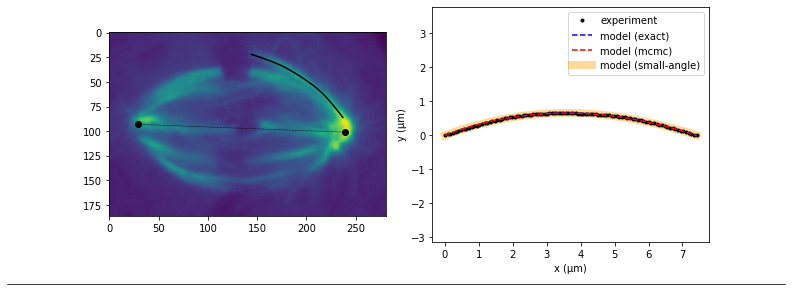

20171215_cell005 2
pole_right
P-K distance (L) =  5.44 um
Initial angle =  15.00 degrees


 10%|▉         | 19/200 [00:00<00:00, 187.79it/s]

number of evaluations = 845


100%|██████████| 200/200 [00:00<00:00, 214.13it/s]


0.022906016912302932 0.16671421631019614 0.027674636590987095 0.016190428563292697
res_mcmc: 0.008229
Exact method error (gradient): 0.0186
Exact method error (mcmc): 0.0200
Small-angle error: 0.0056


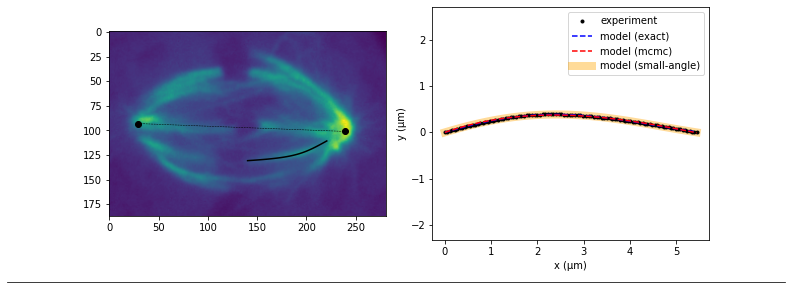

20171219_cell003 0
pole_left
P-K distance (L) =  8.12 um
Initial angle =  9.10 degrees
number of evaluations = 2003


100%|██████████| 200/200 [00:01<00:00, 185.24it/s]


0.02913939775472552 0.03704532669290864 0.0005758750446535614 0.03236960454671856
res_mcmc: 0.081218
Exact method error (gradient): 0.0253
Exact method error (mcmc): 0.0266
Small-angle error: 0.0055


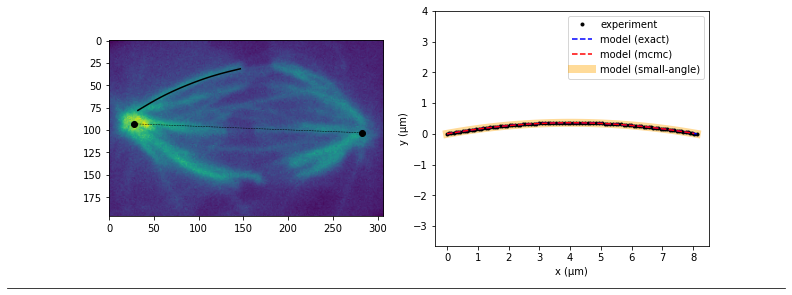

20171219_cell003 1
pole_left
P-K distance (L) =  5.50 um
Initial angle =  8.75 degrees
number of evaluations = 2002


100%|██████████| 200/200 [00:00<00:00, 208.64it/s]


0.19099487139229426 0.04666625671996205 0.007167252360484377 0.007240768969823418
res_mcmc: 0.009613
Exact method error (gradient): 0.0173
Exact method error (mcmc): 0.0169
Small-angle error: 0.0040


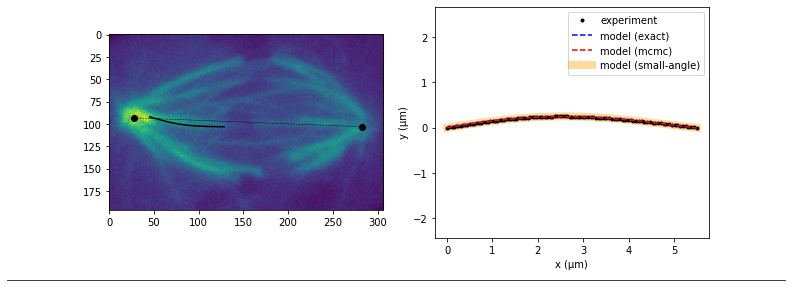

20180611_cell002 0
pole_left
P-K distance (L) =  6.64 um
Initial angle =  22.71 degrees


 10%|█         | 20/200 [00:00<00:00, 190.71it/s]

number of evaluations = 182


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 200/200 [00:00<00:00, 210.96it/s]


0.05636701720173573 0.17032224362069265 0.02462483895963307 0.006742934968766073
res_mcmc: 0.013543
Exact method error (gradient): 0.0162
Exact method error (mcmc): 0.0196
Small-angle error: 0.0091


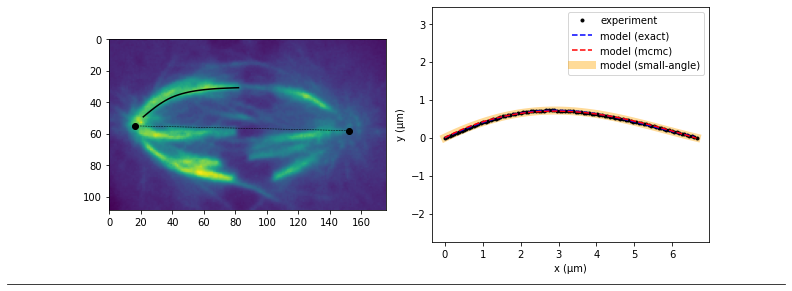

20180611_cell002 1
pole_left
P-K distance (L) =  6.59 um
Initial angle =  21.91 degrees


  0%|          | 0/200 [00:00<?, ?it/s]

number of evaluations = 2004


100%|██████████| 200/200 [00:00<00:00, 208.75it/s]


0.1556856822918137 0.06888043196954369 0.008994866143096412 0.009642746929848456
res_mcmc: 0.018520
Exact method error (gradient): 0.0222
Exact method error (mcmc): 0.0253
Small-angle error: 0.0051


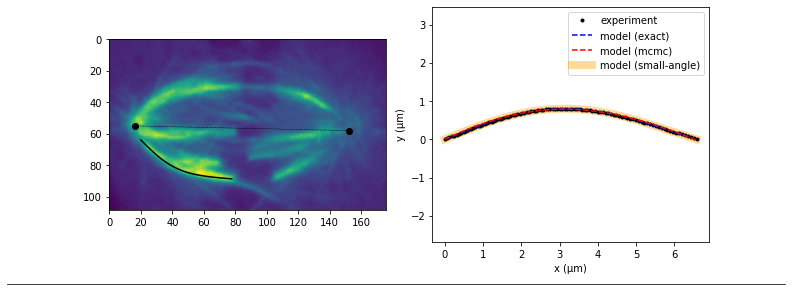

20180611_cell002 2
pole_left
P-K distance (L) =  6.59 um
Initial angle =  21.91 degrees
number of evaluations = 2004


100%|██████████| 200/200 [00:00<00:00, 210.09it/s]


0.16292837674933175 0.06147190417001351 0.008153367918798877 0.0077760922365299814
res_mcmc: 0.018070
Exact method error (gradient): 0.0222
Exact method error (mcmc): 0.0250
Small-angle error: 0.0051


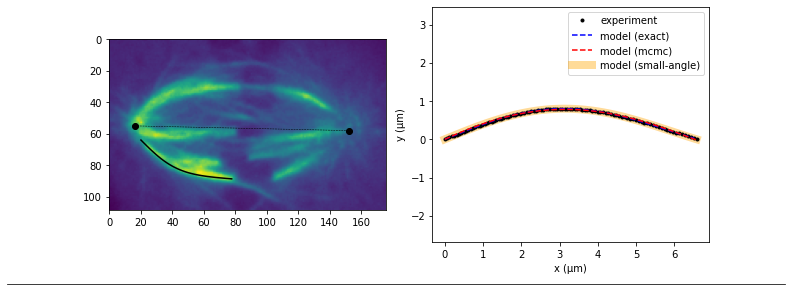

20180620_cell013 0
pole_left
P-K distance (L) =  5.89 um
Initial angle =  4.07 degrees


  0%|          | 0/200 [00:00<?, ?it/s]

number of evaluations = 678


100%|██████████| 200/200 [00:00<00:00, 213.79it/s]


0.29726501973793407 0.001121478657207603 0.00012565306337165735 0.0003819603246946302
res_mcmc: 0.014899
Exact method error (gradient): 0.0189
Exact method error (mcmc): 0.0189
Small-angle error: 0.0040


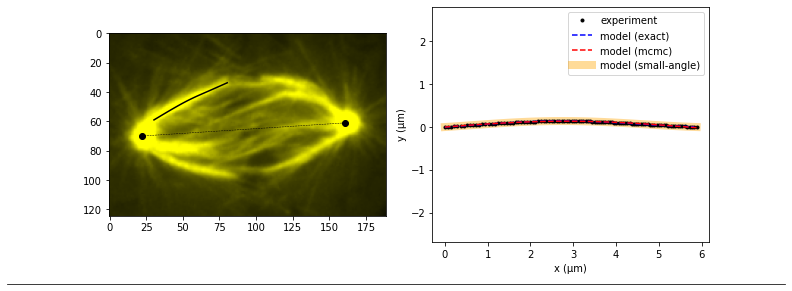

20180620_cell013 1
pole_left
P-K distance (L) =  6.28 um
Initial angle =  16.50 degrees


  0%|          | 0/200 [00:00<?, ?it/s]

number of evaluations = 608


100%|██████████| 200/200 [00:00<00:00, 206.73it/s]


-0.1009606778264164 0.1703720045122903 0.013188172195407126 0.08760881253894291
res_mcmc: 0.013221
Exact method error (gradient): 0.0213
Exact method error (mcmc): 0.0296
Small-angle error: 0.0061


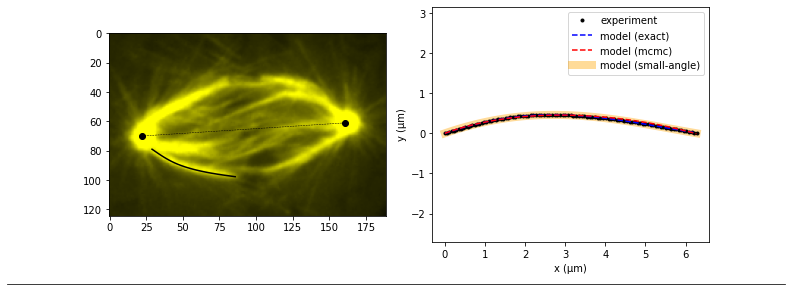

20180620_cell013 2
pole_right
P-K distance (L) =  6.07 um
Initial angle =  7.39 degrees
number of evaluations = 2001


100%|██████████| 200/200 [00:01<00:00, 184.30it/s]


-0.024785206585321157 0.031183821065249504 -0.013693831612142854 0.11431388428590532
res_mcmc: 0.061999
Exact method error (gradient): 0.0166
Exact method error (mcmc): 0.0232
Small-angle error: 0.0046


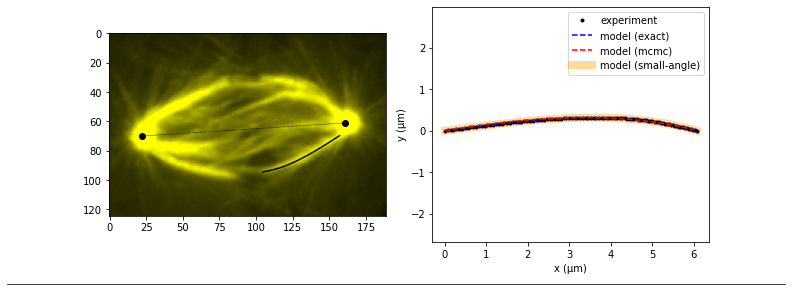

20180622_cell016 0
pole_left
P-K distance (L) =  6.11 um
Initial angle =  13.57 degrees
number of evaluations = 2002


100%|██████████| 200/200 [00:00<00:00, 218.88it/s]


0.23652603094631255 0.019400271955550084 0.003172523282033719 2.3170363450054215e-05
res_mcmc: 0.011950
Exact method error (gradient): 0.0221
Exact method error (mcmc): 0.0228
Small-angle error: 0.0047


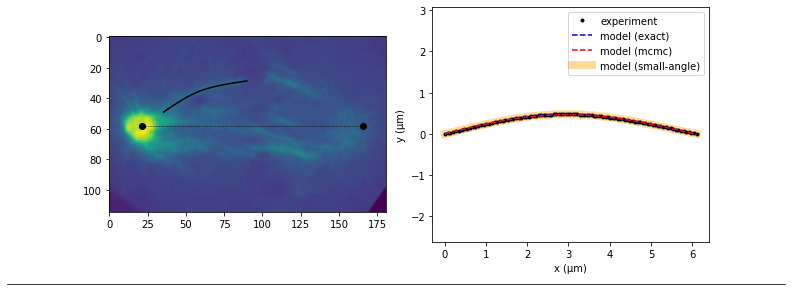

20180622_cell020 0
pole_left
P-K distance (L) =  6.69 um
Initial angle =  28.34 degrees


 10%|█         | 20/200 [00:00<00:00, 189.68it/s]

number of evaluations = 271


100%|██████████| 200/200 [00:01<00:00, 189.73it/s]


-0.10344327848244815 0.2793164759081924 0.028904329040128678 0.0859288957811491
res_mcmc: 0.064976
Exact method error (gradient): 0.0206
Exact method error (mcmc): 0.0219
Small-angle error: 0.0112


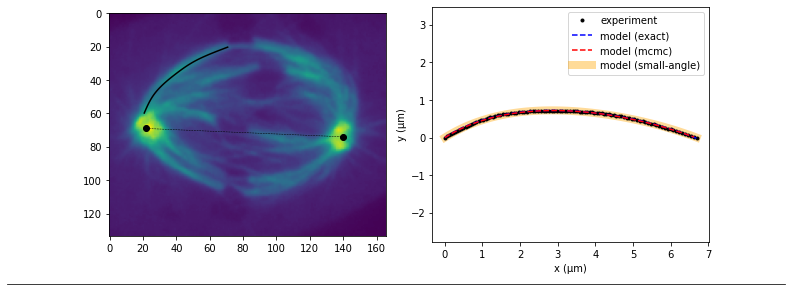

20180622_cell020 1
pole_right
P-K distance (L) =  6.03 um
Initial angle =  24.49 degrees


  0%|          | 0/200 [00:00<?, ?it/s]

number of evaluations = 2002


100%|██████████| 200/200 [00:01<00:00, 197.76it/s]


0.246751682493835 0.010313355333920794 0.0015246136138301696 0.001112938833148681
res_mcmc: 0.014219
Exact method error (gradient): 0.0157
Exact method error (mcmc): 0.0165
Small-angle error: 0.2469


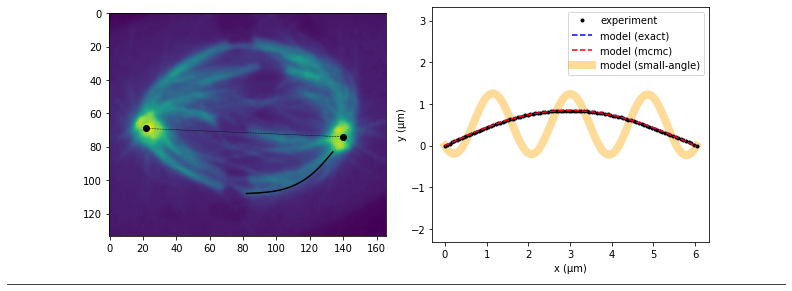

20180622_cell020 2
pole_left
P-K distance (L) =  5.00 um
Initial angle =  13.21 degrees


  0%|          | 0/200 [00:00<?, ?it/s]

number of evaluations = 2000


100%|██████████| 200/200 [00:00<00:00, 220.23it/s]


0.29712148731073174 0.05304557750509854 0.010593564172775856 0.0001049029847708452
res_mcmc: 0.016241
Exact method error (gradient): 0.0105
Exact method error (mcmc): 0.0151
Small-angle error: 0.0051


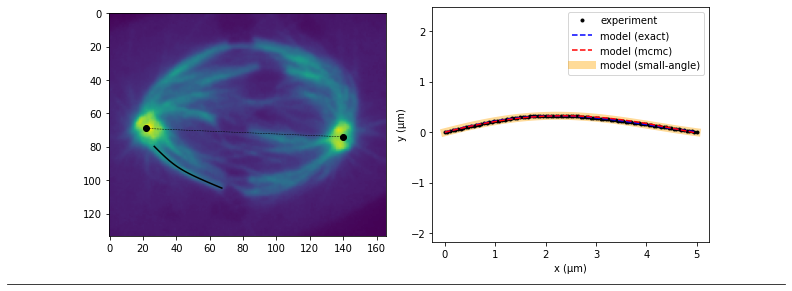

20180622_cell020 3
pole_right
P-K distance (L) =  5.47 um
Initial angle =  25.99 degrees


 10%|▉         | 19/200 [00:00<00:00, 189.88it/s]

number of evaluations = 2002


100%|██████████| 200/200 [00:00<00:00, 206.69it/s]


0.18507113073347617 0.1318424026812123 0.023867398084605248 0.0013909345388036232
res_mcmc: 0.002788
Exact method error (gradient): 0.0164
Exact method error (mcmc): 0.0165
Small-angle error: 0.0048


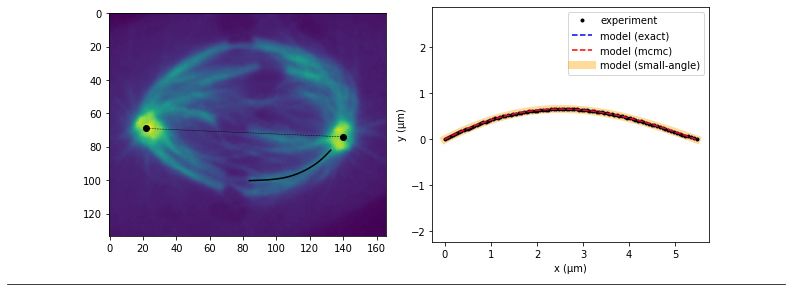

20180628_cell002 0
pole_left
P-K distance (L) =  7.16 um
Initial angle =  15.71 degrees
number of evaluations = 2002


100%|██████████| 200/200 [00:01<00:00, 184.84it/s]


0.12314346597365616 0.04750341055800711 0.004613108973634786 0.0144911037917438
res_mcmc: 0.011745
Exact method error (gradient): 0.0246
Exact method error (mcmc): 0.0240
Small-angle error: 0.0047


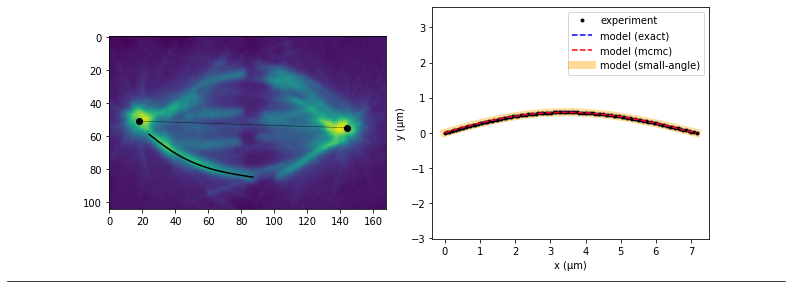

20180628_cell010 0
pole_left
P-K distance (L) =  5.65 um
Initial angle =  18.30 degrees


 10%|█         | 20/200 [00:00<00:00, 196.53it/s]

number of evaluations = 2001


100%|██████████| 200/200 [00:00<00:00, 213.93it/s]


0.234250675688624 0.05583908369872172 0.009106097933240022 0.004349353672297086
res_mcmc: 0.010052
Exact method error (gradient): 0.0168
Exact method error (mcmc): 0.0202
Small-angle error: 0.0054


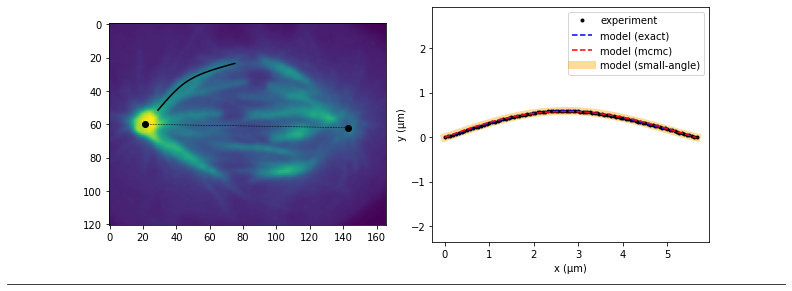

20180628_cell010 1
pole_left
P-K distance (L) =  3.77 um
Initial angle =  13.11 degrees
number of evaluations = 2000


100%|██████████| 200/200 [00:01<00:00, 199.52it/s]


0.3267466010665806 0.12210496995125436 0.025892171009417493 0.024542208576280172
res_mcmc: 0.019557
Exact method error (gradient): 0.0111
Exact method error (mcmc): 0.0118
Small-angle error: 0.0030


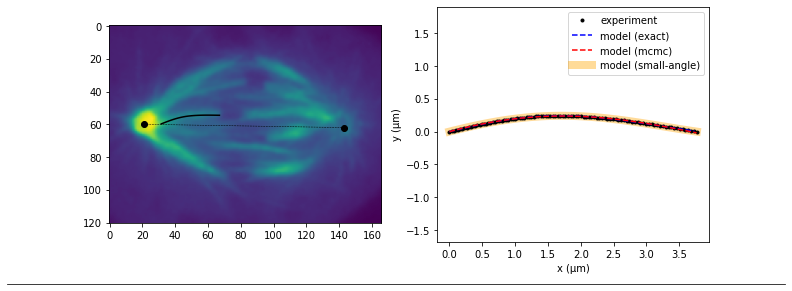

20180628_cell010 2
pole_left
P-K distance (L) =  5.36 um
Initial angle =  10.08 degrees
number of evaluations = 2002


100%|██████████| 200/200 [00:00<00:00, 203.91it/s]


0.011365948955867271 0.059360340632029655 -0.005485111113188758 0.08874334302957604
res_mcmc: 0.004890
Exact method error (gradient): 0.0158
Exact method error (mcmc): 0.0158
Small-angle error: 0.0037


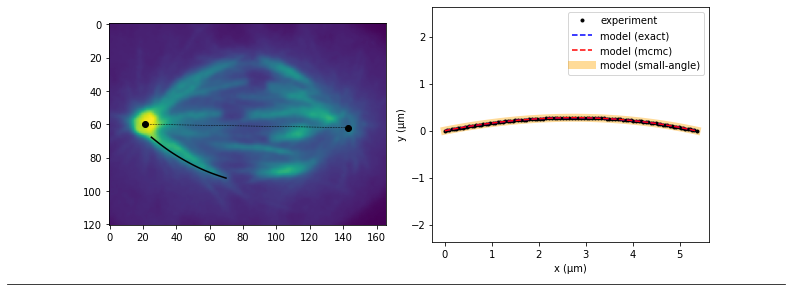

20180628_cell010 3
pole_right
P-K distance (L) =  5.25 um
Initial angle =  12.63 degrees


 10%|█         | 21/200 [00:00<00:00, 201.52it/s]

number of evaluations = 69


100%|██████████| 200/200 [00:00<00:00, 211.90it/s]


-0.020042306218984084 0.165956978408831 0.02368430686622489 0.041517009375918415
res_mcmc: 0.018564
Exact method error (gradient): 0.0168
Exact method error (mcmc): 0.0266
Small-angle error: 0.0081


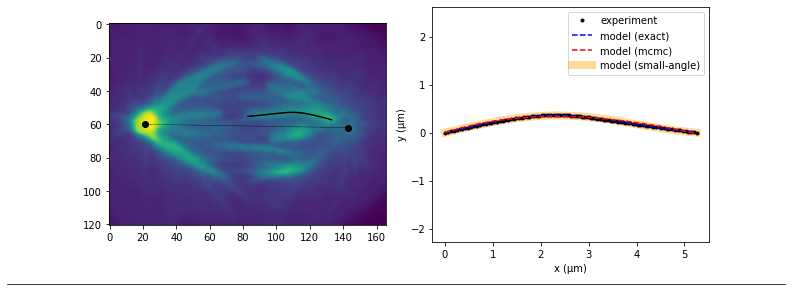

20180810_cell005 0
pole_left
P-K distance (L) =  5.53 um
Initial angle =  16.72 degrees
number of evaluations = 458


100%|██████████| 200/200 [00:01<00:00, 197.35it/s]


0.24162760142685846 0.047131426717032174 0.006024794514484998 0.01379459173817222
res_mcmc: 0.015082
Exact method error (gradient): 0.0165
Exact method error (mcmc): 0.0176
Small-angle error: 0.0039


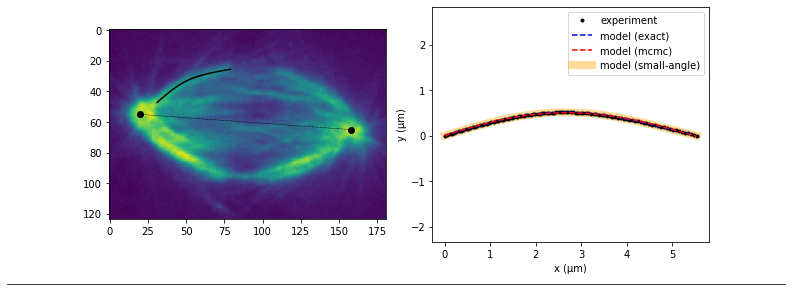

20180810_cell005 1
pole_right
P-K distance (L) =  5.86 um
Initial angle =  16.98 degrees
number of evaluations = 2002


100%|██████████| 200/200 [00:01<00:00, 188.21it/s]


-0.07385249169010598 0.20944790531820506 0.03391182028231272 0.01057655156804313
res_mcmc: 0.018216
Exact method error (gradient): 0.0168
Exact method error (mcmc): 0.0174
Small-angle error: 0.0035


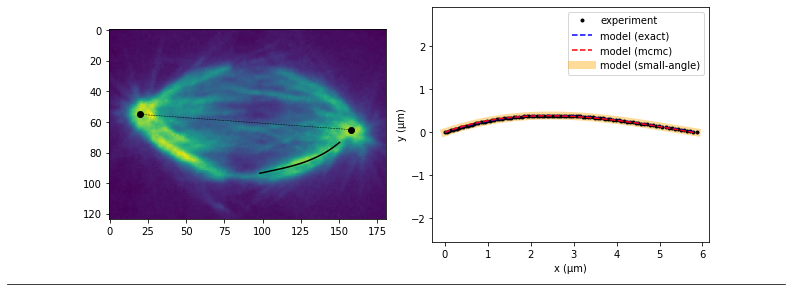

20180810_cell005 2
pole_left
P-K distance (L) =  6.05 um
Initial angle =  11.13 degrees


  0%|          | 0/200 [00:00<?, ?it/s]

number of evaluations = 2001


100%|██████████| 200/200 [00:00<00:00, 228.35it/s]


0.25168640852034907 0.0007571349361128272 -0.0012964172084737324 0.008601103211708934
res_mcmc: 0.002563
Exact method error (gradient): 0.0174
Exact method error (mcmc): 0.0190
Small-angle error: 0.0038


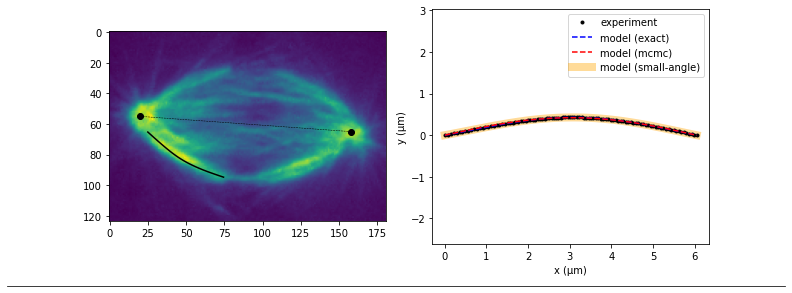

20180810_cell006 0
pole_left
P-K distance (L) =  5.45 um
Initial angle =  9.95 degrees


  0%|          | 0/200 [00:00<?, ?it/s]

number of evaluations = 2000


100%|██████████| 200/200 [00:00<00:00, 214.39it/s]


0.010642609993999214 0.07835375388920228 0.00817381128827923 0.0338238832365056
res_mcmc: 0.003912
Exact method error (gradient): 0.0167
Exact method error (mcmc): 0.0167
Small-angle error: 0.0037


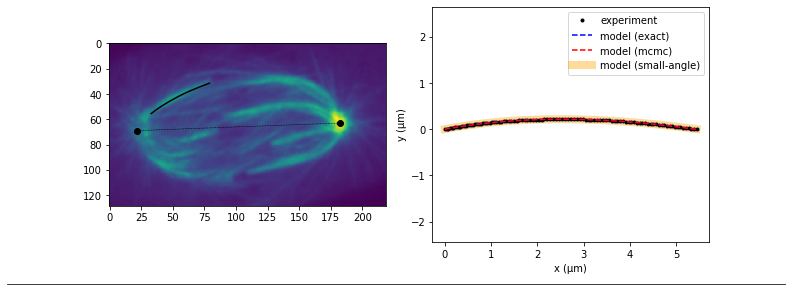

20180810_cell006 1
pole_right
P-K distance (L) =  8.93 um
Initial angle =  28.80 degrees


 10%|█         | 21/200 [00:00<00:00, 204.10it/s]

number of evaluations = 97


100%|██████████| 200/200 [00:00<00:00, 220.81it/s]


0.02994237223838401 0.1430251597010986 0.01598556794900094 0.0003265641047342227
res_mcmc: 0.074814
Exact method error (gradient): 0.0303
Exact method error (mcmc): 0.0635
Small-angle error: 0.0118


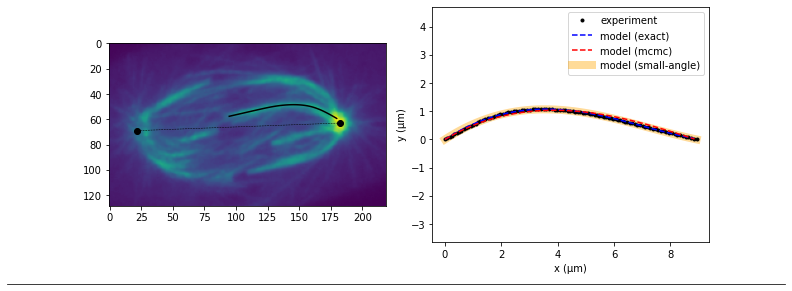

20180810_cell006 2
pole_right
P-K distance (L) =  4.95 um
Initial angle =  6.79 degrees
number of evaluations = 2000


100%|██████████| 200/200 [00:00<00:00, 205.41it/s]


0.09635222473965098 0.06358203209728312 0.01075812061989881 0.010345948525270876
res_mcmc: 0.002039
Exact method error (gradient): 0.0146
Exact method error (mcmc): 0.0139
Small-angle error: 0.0030


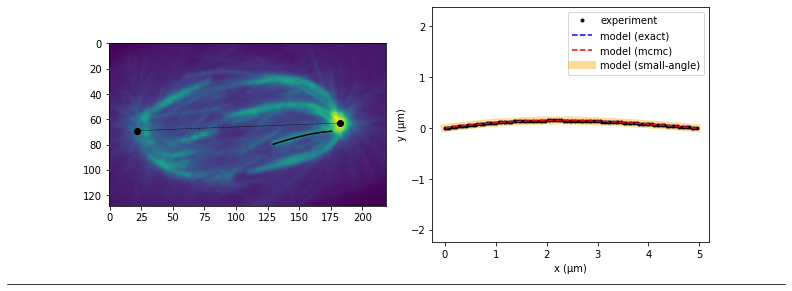

20180810_cell006 3
pole_right
P-K distance (L) =  8.32 um
Initial angle =  32.25 degrees


 10%|▉         | 19/200 [00:00<00:00, 189.60it/s]

number of evaluations = 73


100%|██████████| 200/200 [00:00<00:00, 210.22it/s]


-0.045594004771279714 0.2692251270619672 0.03178968944355641 0.004862964061002506
res_mcmc: 0.069471
Exact method error (gradient): 0.0335
Exact method error (mcmc): 0.0488
Small-angle error: 0.0193


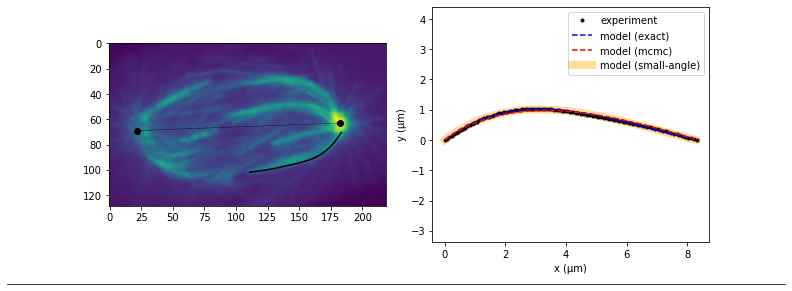

20210526_cell001 0
pole_left
P-K distance (L) =  7.11 um
Initial angle =  11.91 degrees
number of evaluations = 2002


100%|██████████| 200/200 [00:00<00:00, 218.68it/s]


0.1693513962398842 0.013139632249928174 0.000891540445560933 0.0068025021752193306
res_mcmc: 0.015942
Exact method error (gradient): 0.0194
Exact method error (mcmc): 0.0201
Small-angle error: 0.0048


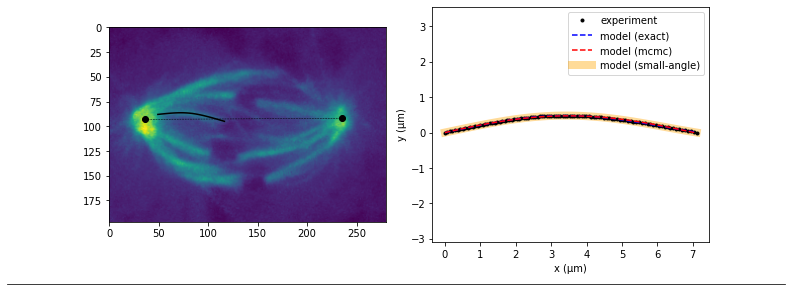

20210526_cell001 1
pole_right
P-K distance (L) =  10.57 um
Initial angle =  24.21 degrees


 10%|█         | 20/200 [00:00<00:00, 193.72it/s]

number of evaluations = 2003


100%|██████████| 200/200 [00:00<00:00, 219.01it/s]


-0.029308306143086417 0.16574144098180602 0.014866796151937449 0.008599695111261074
res_mcmc: 0.009931
Exact method error (gradient): 0.0352
Exact method error (mcmc): 0.0410
Small-angle error: 0.0081


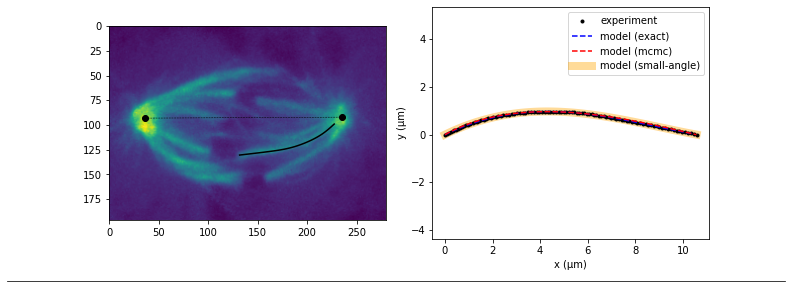

20210526_cell001 2
pole_right
P-K distance (L) =  8.96 um
Initial angle =  16.00 degrees


 10%|█         | 21/200 [00:00<00:00, 203.10it/s]

number of evaluations = 429


100%|██████████| 200/200 [00:00<00:00, 204.11it/s]


-0.04957466398300491 0.15235945086699268 0.01613239848860835 0.007801965207911571
res_mcmc: 0.008467
Exact method error (gradient): 0.0305
Exact method error (mcmc): 0.0341
Small-angle error: 0.0110


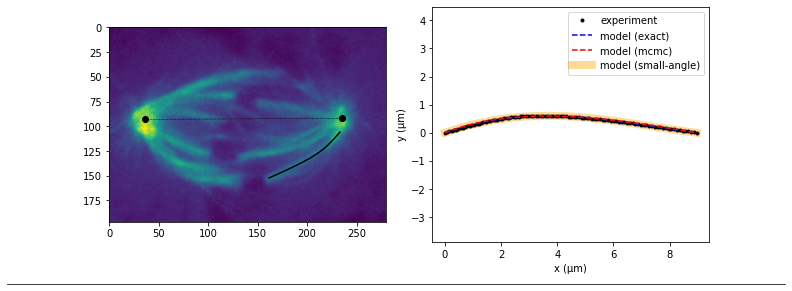

20210526_cell001 3
pole_left
P-K distance (L) =  13.48 um
Initial angle =  15.17 degrees


 10%|█         | 20/200 [00:00<00:00, 195.45it/s]

number of evaluations = 562


100%|██████████| 200/200 [00:00<00:00, 208.10it/s]


0.031844584897723335 0.008942279007348748 -0.0015905202000781593 0.030383158601677826
res_mcmc: 0.138371
Exact method error (gradient): 0.0357
Exact method error (mcmc): 0.0384
Small-angle error: 0.0110


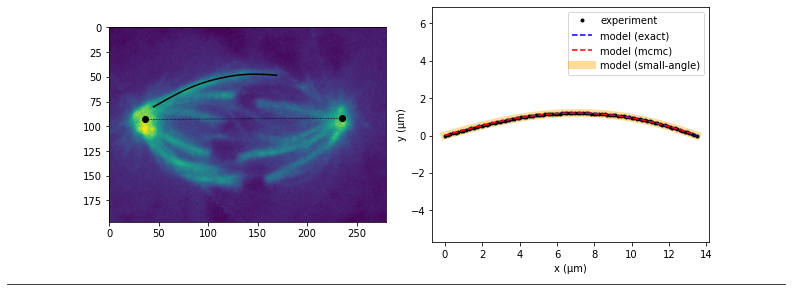

20210526_cell001 4
pole_right
P-K distance (L) =  7.30 um
Initial angle =  4.63 degrees
number of evaluations = 2003


100%|██████████| 200/200 [00:01<00:00, 121.93it/s]


0.18065237884748772 0.0025185167029148914 0.0003197969095119221 0.0001848949574993308
res_mcmc: 0.008032
Exact method error (gradient): 0.0195
Exact method error (mcmc): 0.0183
Small-angle error: 0.0043


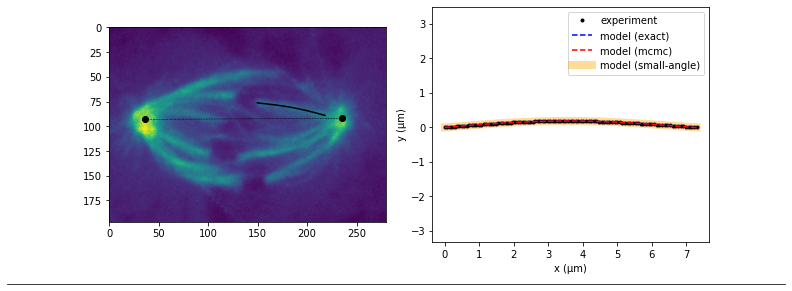

20210526_cell004 0
pole_left
P-K distance (L) =  10.42 um
Initial angle =  12.33 degrees


  0%|          | 0/200 [00:00<?, ?it/s]

number of evaluations = 131


100%|██████████| 200/200 [00:01<00:00, 196.36it/s]


-0.0022416122987844386 0.07739912617088882 0.006566242056508333 0.00899260503010918
res_mcmc: 0.103895
Exact method error (gradient): 0.0318
Exact method error (mcmc): 0.0371
Small-angle error: 0.0093


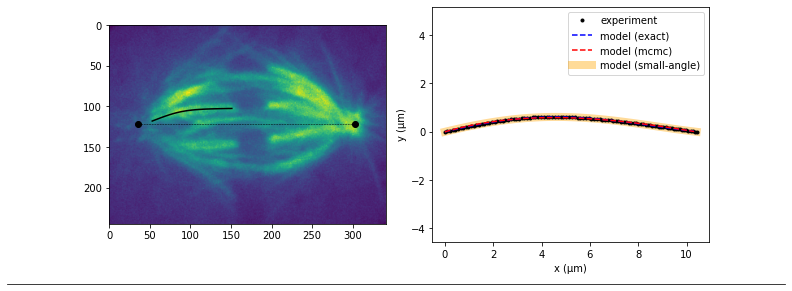

20210526_cell004 1
pole_left
P-K distance (L) =  10.60 um
Initial angle =  16.54 degrees


 10%|█         | 21/200 [00:00<00:00, 200.73it/s]

number of evaluations = 1991


100%|██████████| 200/200 [00:00<00:00, 209.85it/s]


0.008452578852860604 0.09039348183114779 0.008041823738032932 0.0051130762638633975
res_mcmc: 0.003932
Exact method error (gradient): 0.0359
Exact method error (mcmc): 0.0385
Small-angle error: 0.0127


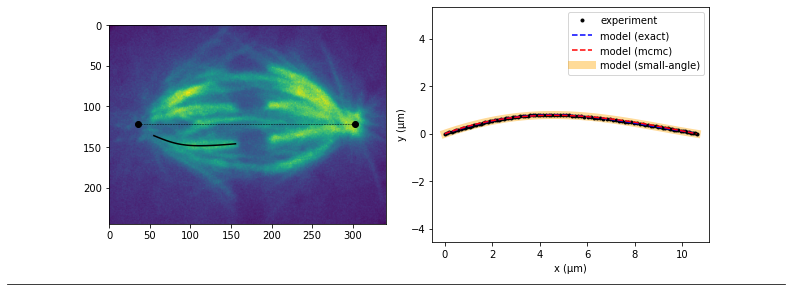

20210526_cell004 2
pole_right
P-K distance (L) =  10.32 um
Initial angle =  21.96 degrees


 10%|▉         | 19/200 [00:00<00:00, 187.30it/s]

number of evaluations = 110


100%|██████████| 200/200 [00:00<00:00, 206.05it/s]


-0.0009403578307454197 0.13774679063250428 0.01233921401612138 0.010426414885135127
res_mcmc: 0.100431
Exact method error (gradient): 0.0364
Exact method error (mcmc): 0.0523
Small-angle error: 0.0176


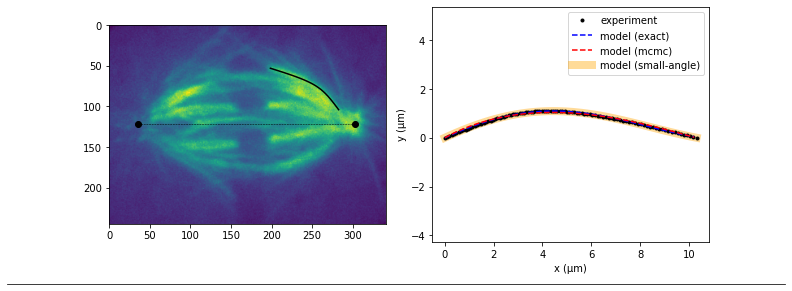

20210526_cell004 3
pole_right
P-K distance (L) =  7.48 um
Initial angle =  11.65 degrees
number of evaluations = 552


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 200/200 [00:00<00:00, 208.51it/s]


0.08883916893457702 0.054387412936462425 0.006606032000746189 0.0050028609945378735
res_mcmc: 0.010208
Exact method error (gradient): 0.0251
Exact method error (mcmc): 0.0251
Small-angle error: 0.0056


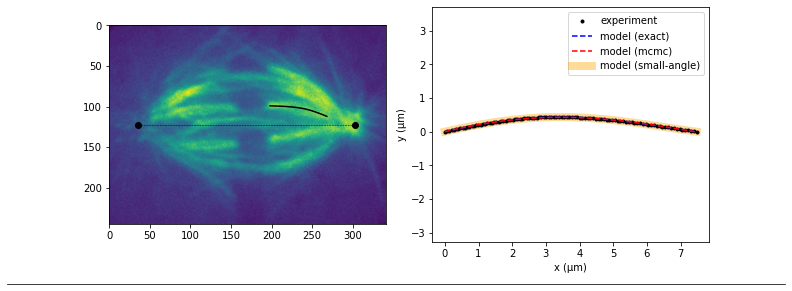

20210526_cell004 4
pole_right
P-K distance (L) =  8.60 um
Initial angle =  1.56 degrees
number of evaluations = 2001


100%|██████████| 200/200 [00:00<00:00, 249.07it/s]


-0.13277133069709798 0.011229333964430663 -0.0011735198759838775 0.021319242656828732
res_mcmc: 0.010173
Exact method error (gradient): 0.0194
Exact method error (mcmc): 0.0198
Small-angle error: 0.0055


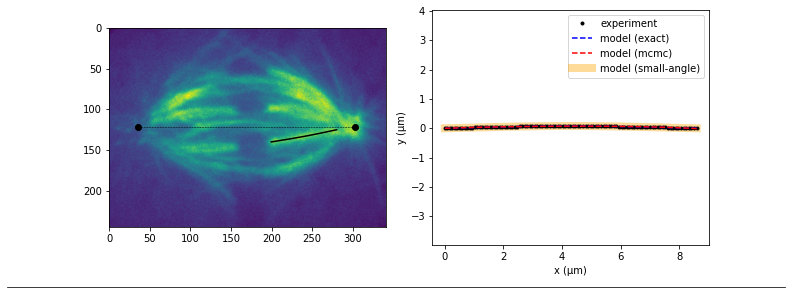

20210526_cell004 5
pole_right
P-K distance (L) =  10.24 um
Initial angle =  22.64 degrees
number of evaluations = 975


100%|██████████| 200/200 [00:00<00:00, 201.74it/s]


0.03740780544481045 0.08395107394287538 0.0074933329698400825 0.007238077664137518
res_mcmc: 0.003501
Exact method error (gradient): 0.0334
Exact method error (mcmc): 0.0321
Small-angle error: 0.0093


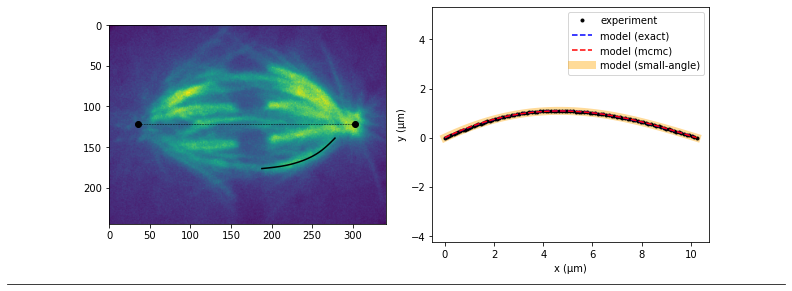

20210526_cell006 0
pole_left
P-K distance (L) =  8.55 um
Initial angle =  14.35 degrees


  0%|          | 0/200 [00:00<?, ?it/s]

number of evaluations = 2003


100%|██████████| 200/200 [00:01<00:00, 150.79it/s]


0.10191759354044748 0.02989494228103019 0.0031797577052521636 0.0027067064664001265
res_mcmc: 0.014755
Exact method error (gradient): 0.0243
Exact method error (mcmc): 0.0250
Small-angle error: 0.0062


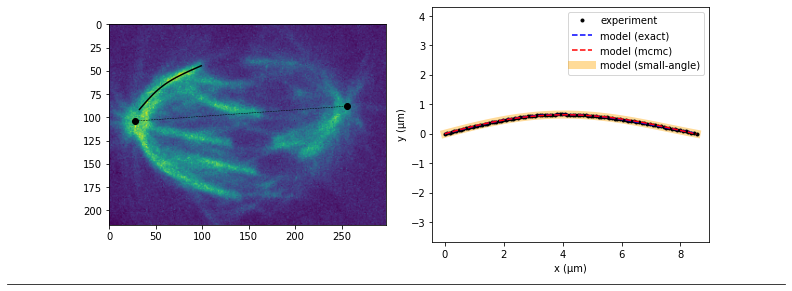

20210526_cell006 1
pole_left
P-K distance (L) =  13.26 um
Initial angle =  30.14 degrees


  7%|▋         | 14/200 [00:00<00:01, 136.57it/s]

number of evaluations = 665


100%|██████████| 200/200 [00:01<00:00, 163.56it/s]


0.039265653787645814 0.02356094777405065 0.0006728105041573092 0.014642300802266986
res_mcmc: 0.116470
Exact method error (gradient): 0.0558
Exact method error (mcmc): 0.1888
Small-angle error: 0.0283


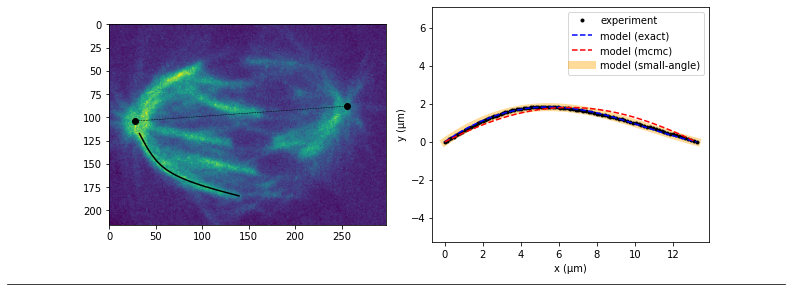

20210526_cell006 2
pole_left
P-K distance (L) =  9.00 um
Initial angle =  2.39 degrees
number of evaluations = 2001


100%|██████████| 200/200 [00:01<00:00, 181.87it/s]


-0.05202219330251554 0.015640775947688573 -0.00010247819147109118 0.016563303174402546
res_mcmc: 0.011095
Exact method error (gradient): 0.0276
Exact method error (mcmc): 0.0265
Small-angle error: 0.0055


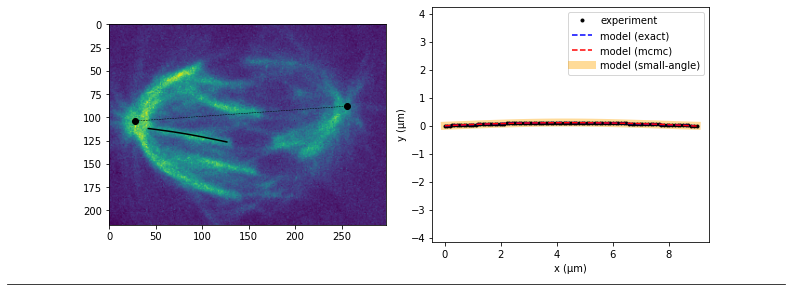

20210526_cell007 0
pole_left
P-K distance (L) =  8.61 um
Initial angle =  12.54 degrees


  0%|          | 0/200 [00:00<?, ?it/s]

number of evaluations = 104


100%|██████████| 200/200 [00:00<00:00, 225.28it/s]


0.027110712536480883 0.0765130790730306 0.008746994416626887 0.0012014571458731083
res_mcmc: 0.007760
Exact method error (gradient): 0.0253
Exact method error (mcmc): 0.0255
Small-angle error: 0.0071


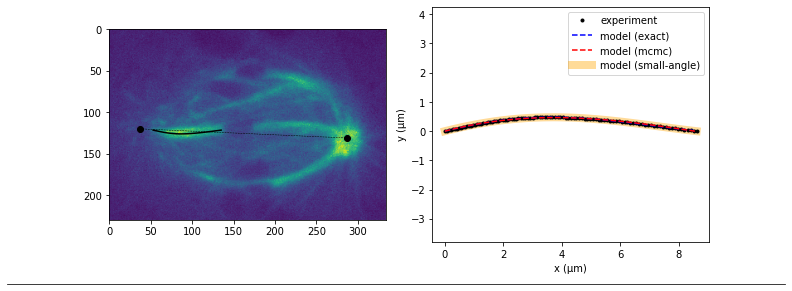

20210526_cell007 1
pole_right
P-K distance (L) =  10.99 um
Initial angle =  17.37 degrees


  0%|          | 0/200 [00:00<?, ?it/s]

number of evaluations = 2001


100%|██████████| 200/200 [00:00<00:00, 208.51it/s]


-0.01936559429049912 0.11051935478020732 0.00936426395541172 0.007627754777998014
res_mcmc: 0.009401
Exact method error (gradient): 0.0387
Exact method error (mcmc): 0.0376
Small-angle error: 0.0103


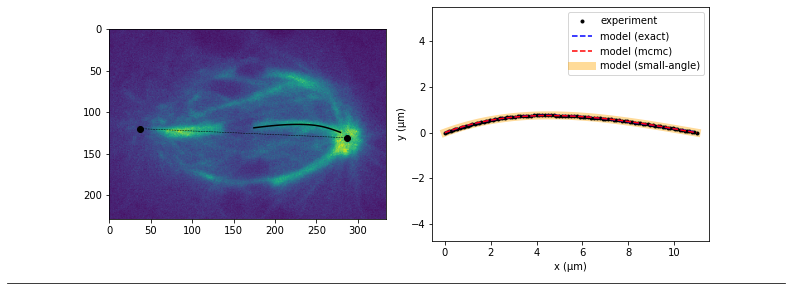

20210526_cell007 2
pole_right
P-K distance (L) =  8.85 um
Initial angle =  17.35 degrees
number of evaluations = 2001


100%|██████████| 200/200 [00:00<00:00, 216.04it/s]


0.07772999269574073 0.048269087619694485 0.00463182926308859 0.007270422051564224
res_mcmc: 0.005354
Exact method error (gradient): 0.0291
Exact method error (mcmc): 0.0277
Small-angle error: 0.0071


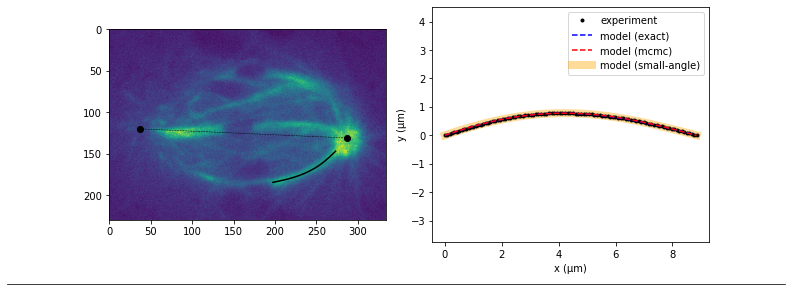

20210526_cell007 3
pole_right
P-K distance (L) =  11.33 um
Initial angle =  41.81 degrees


 10%|█         | 20/200 [00:00<00:00, 196.06it/s]

number of evaluations = 75


100%|██████████| 200/200 [00:00<00:00, 204.66it/s]


-0.03671451689188535 0.27589113208456234 0.017028942838390175 0.08297962198843817
res_mcmc: 0.027961
Exact method error (gradient): 0.0512
Exact method error (mcmc): 0.0806
Small-angle error: 0.0237


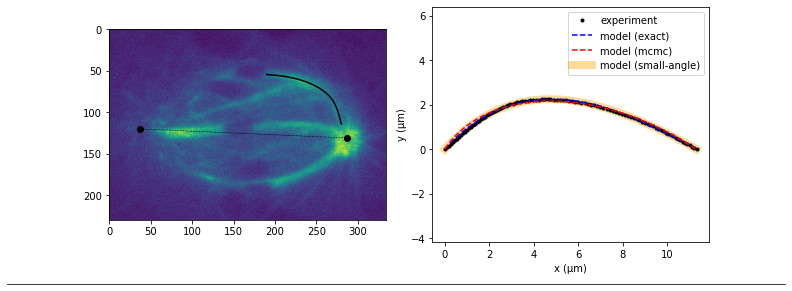

In [39]:
df_fin = pd.DataFrame()

path = "../../dat/WT_unmanip_20210722/"
cells = sorted(glob.glob("%s/*"%path))

force_PP = False
show_details = True
Rx_zero = False
Ry_zero = False

n_dim = 4        # number of parameters in the model
n_walkers = 10   # number of MCMC walkers
n_steps = 200    # number of MCMC steps during each filtering round
n_filter = 2     # number of sampling restarts from the optimal position
sigma_start = 0.02 # standard deviation of the random multiplying factor centered
                   # around 1, used to randomize the initial positions of the walkers
cols = ['Rx', 'M0', 'Ry', 'theta0']

for cell in cells:

    spindle = cell.split("/")[-1].split(".")[0]
    image = mpimg.imread("%s/%s_before.tif"%(cell,spindle))
    profiles = sorted(list(set(glob.glob("%s/*.csv"%cell)) - set(glob.glob("%s/*poles.csv"%cell))))
    pole_csv = glob.glob("%s/*poles.csv"%cell)[-1]
    
    for profile in profiles:
        
        kfiber_number = profile.split("/")[-1].split(".")[0].split("_")[-1]
        print(spindle, kfiber_number)
#         if spindle!="20180620_cell013":
#             continue
        
        fig, ax = plt.subplots(1, 2, figsize = (9, 4))
    
        # Raw data input
        df_profile = pd.read_csv(profile)
        df_pole = pd.read_csv(pole_csv)
        
        x_dat = np.array(df_profile["X"].values)
        y_dat = np.array(df_profile["Y"].values)
        
        # Show the spindle image & overlaid k-fiber profile
        ax[0].imshow(image)
        ax[0].plot(x_dat, y_dat, color = 'k')
        
        
        # Pole coordinates & plotting
        P1x = np.array(df_pole["X"].values)[0]
        P1y = np.array(df_pole["Y"].values)[0]
        P2x = np.array(df_pole["X"].values)[1]
        P2y = np.array(df_pole["Y"].values)[1]
        ax[0].scatter([P1x, P2x], [P1y, P2y], color='k')
        ax[0].plot([P1x, P2x], [P1y, P2y], color='k', ls='--', lw=0.5)
        
        # Angle that the pole-kinetochore line
        # forms with the pole-pole axis
        PP_vector = [P2x-P1x, P2y-P1y]
        K_vector = [x_dat[-1]-x_dat[0], y_dat[-1]-y_dat[0]]
        unit_PP_vector = PP_vector / np.linalg.norm(PP_vector)
        unit_K_vector = K_vector / np.linalg.norm(K_vector)
        dot_product = np.dot(unit_PP_vector, unit_K_vector)
        PP_K_angle = np.arccos(dot_product)
        if PP_K_angle > np.pi/2:
            PP_K_angle = np.pi - PP_K_angle
        
        # Identify the spindle side in which the k-fiber lies
        x_mean = np.mean(x_dat)
        y_mean = np.mean(y_dat)
        dist_P1 = np.sqrt((x_mean-P1x)**2 + (y_mean-P1y)**2)
        dist_P2 = np.sqrt((x_mean-P2x)**2 + (y_mean-P2y)**2)
        if dist_P2 < dist_P1:
            pole = "pole_right"
            x_dat = -x_dat
        else:
            pole = "pole_left"
        
        # Rotate to have the end-points at y=0
        angle = np.arctan((y_dat[-1] - y_dat[0]) / (x_dat[-1] - x_dat[0]))
        x_dat, y_dat = rotate(x_dat, y_dat, angle)
        
        # Translation to start at origin
        x_dat -= x_dat[0]
        y_dat -= y_dat[0]
        
        # Flipping to ensure a positive initial slope
        theta0 = np.arctan2(y_dat[3]-y_dat[0], x_dat[3]-x_dat[0])
        if theta0 < 0.0:
            y_dat = -y_dat
            angle = -angle
        
        # Convert from pixel to micron units based on scope camera calibration
        is_2017 = re.search('2017',profile)
        if is_2017:
            scope_calibration = 0.0657
        else:
            scope_calibration = 0.105

        x_dat = x_dat*scope_calibration
        y_dat = y_dat*scope_calibration

        # Pole-kinetochore (P-K) distance
        L = x_dat[-1] - x_dat[0]
        
        # Initial angle in the rotated profile
        theta_init = np.arctan2(y_dat[3]-y_dat[0], x_dat[3]-x_dat[0])
        
        if show_details:
            print(pole)
            print("P-K distance (L) =  %.2f um" % L)
            print("Initial angle =  %.2f degrees" % np.degrees(theta_init))
            
        
#         # Flip the profile (to test the Mp=0 case)
#         x_dat = L - x_dat
#         x_dat = np.flip(x_dat)
#         y_dat = np.flip(y_dat)
        
        
        # ----------------- Parameter inference: Large angle ----------------- #
        error_min = np.inf
        length_conserved = True
        end_match = False

        for M0_init in np.logspace(-2,0.5,5)/L:
            for Ry_init in np.logspace(-2,0.5,5)/L:
                param_init = np.array([0.0, M0_init, Ry_init, theta_init])
                args = (x_dat, y_dat, L, angle, length_conserved, end_match, Rx_zero, Ry_zero, force_PP)
                output = scipy.optimize.least_squares(res_fn_exact, param_init, args=args, method="lm")

                if error_min > output.cost:
                    error_min = output.cost
                    p_opt_contour = output.x
        
        length_conserved = False
        end_match = True
        args = (x_dat, y_dat, L, angle, length_conserved, end_match, Rx_zero, Ry_zero, force_PP)
        output = scipy.optimize.least_squares(res_fn_exact, p_opt_contour, args=args, method="lm")
        
        num_eval = output.nfev
        p_opt_exact = output.x
        
        if show_details:
            print("number of evaluations = %s"% num_eval)

        M0_opt_exact = p_opt_exact[1]
        theta0_opt_exact = p_opt_exact[3]
            
        if Rx_zero:
            Rx_opt_exact = 0
        else:
            Rx_opt_exact = p_opt_exact[0]
            
        if Ry_zero:
            Ry_opt_exact = 0
        else:
            Ry_opt_exact = p_opt_exact[2]

        
        # ----------------- Parameter inference: Small angle ----------------- #
        param_init = np.array([0.9*Rx_opt_exact, M0_opt_exact, Ry_opt_exact])
        args = (x_dat, y_dat, L, Rx_zero, Ry_zero)
        output = scipy.optimize.least_squares(residual_small_angle, param_init, args=args, method="lm")
        p_opt = output.x
        
        if Rx_zero:
            Rx_opt = 0
        else:
            Rx_opt = p_opt[0]
            
        if Ry_zero:
            Ry_opt = 1e-6
            M0_opt = Ry_opt*L
        else:
            M0_opt = p_opt[1] # Mk=0
            Ry_opt = p_opt[2]
        
        
        # ----------------- Parameter inference: MCMC ----------------- #
        length_conserved = False
        end_match = True
        
        p_init = np.copy(p_opt_exact)
        p_init[1] = np.abs(p_init[1])
        p_init[2] = 0.0
        p_init_mat = np.tile(p_init, (n_walkers, 1))
        
        args = (x_dat, y_dat, L, angle, length_conserved, end_match, Rx_zero, Ry_zero, force_PP)
        sampler = emcee.EnsembleSampler(n_walkers, n_dim, logpost_exact, args=args, threads=3)
        
        p_opt_mat = p_init_mat
        for k in range(n_filter):
            for j in range(n_dim):
                p_opt_mat[:,j] *= np.random.normal(1.0, sigma_start, n_walkers)
                p_opt_mat[:,j] += np.random.normal(1e-4, 1e-5, n_walkers)
            _ = sampler.run_mcmc(p_opt_mat, n_steps, progress=True)
            df_mcmc = sampler_to_dataframe(sampler, columns=cols)
            p_opt_mcmc = df_mcmc[df_mcmc['lnprob']==df_mcmc['lnprob'].max()].values[0][:-2]
            for j in range(n_dim):
                p_opt_mat[:,j] = p_opt_mcmc[j]*np.random.normal(1.0, sigma_start, n_walkers)
                
        if Rx_zero:
            Rx_opt_mcmc = 0
        else:
            Rx_opt_mcmc = p_opt_mcmc[0]
            
        if Ry_zero:
            Ry_opt_mcmc = 0
            M0_opt_mcmc = 0
        else:
            M0_opt_mcmc =  p_opt_mcmc[1]
            Ry_opt_mcmc = p_opt_mcmc[2]
#             M0_opt_mcmc = Ry_opt_mcmc*L #Mk=0
        theta0_opt_mcmc = p_opt_mcmc[3]
        
        
        # ----------------- Plot the fits ----------------- #
        x_exact, y_exact = deflection_exact(p_opt_exact, x_dat, y_dat, L, angle, length_conserved=False,\
                                            Rx_zero=Rx_zero, Ry_zero=Ry_zero, force_PP=force_PP)
        y_exact = y_exact[x_exact <= L]
        x_exact = x_exact[x_exact <= L]
        
        x_mcmc, y_mcmc = deflection_exact(p_opt_mcmc, x_dat, y_dat, L, angle, length_conserved=False,\
                                          Rx_zero=Rx_zero, Ry_zero=Ry_zero, force_PP=force_PP)
        y_mcmc = y_mcmc[x_mcmc <= L]
        x_mcmc = x_mcmc[x_mcmc <= L]
        
        x_small_angle = x_dat
        y_small_angle = deflection_small_angle(p_opt, x_dat, L, Rx_zero=Rx_zero, Ry_zero=Ry_zero)
        
        ax[1].plot(x_dat, y_dat, '.', color = 'k', lw = 2, label = 'experiment', zorder=2)
        ax[1].plot(x_exact, y_exact, '--', color = 'blue', label = 'model (exact)', zorder=10)
        ax[1].plot(x_mcmc, y_mcmc, '--', color = 'red', label = 'model (mcmc)', zorder=20)
        ax[1].plot(x_small_angle, y_small_angle, color = 'orange', \
                   label = 'model (small-angle)', lw = 8, alpha = 0.4, zorder=1)
        ax[1].legend()
        ax[1].set_xlabel('x (μm)')
        ax[1].set_ylabel('y (μm)')
        ax[1].axis('equal')
        
        print(Rx_opt_mcmc,M0_opt_mcmc,Ry_opt_mcmc, M0_opt_mcmc - (Ry_opt_mcmc*L))    
        
        # --------- Error metrics --------- #
        
        res_exact, _ = distances_pair_min(x_dat, y_dat, x_exact, y_exact)
        err_exact = np.sqrt(np.mean(res_exact**2))
        
        res_mcmc, _ = distances_pair_min(x_dat, y_dat, x_mcmc, y_mcmc)
        err_mcmc = np.sqrt(np.mean(res_mcmc**2))

        print('res_mcmc: %2f' % res_mcmc[-1])
        
        res = residual_small_angle(p_opt, x_dat, y_dat, L)
        err = np.sqrt(np.mean(res**2))
        
        if show_details:
            print("Exact method error (gradient): %.4f"%err_exact)
            print("Exact method error (mcmc): %.4f"%err_mcmc)
            print("Small-angle error: %.4f"%err)
            
        # Largest y-deflections
        gap_max_exact = np.max(res_exact)
        gap_max_mcmc = np.max(res_mcmc)
        gap_max_small_angle = np.max(res)
        

        df_fin = df_fin.append({'Spindle': spindle,
                                'Kfiber': kfiber_number,
                                'Pole': pole, 
                                'PP-K angle (deg)': np.degrees(PP_K_angle), 
                                'x_dat': x_dat,
                                'y_dat': y_dat,
                                'L': L,
                                'x (exact)': x_exact,
                                'y (exact)': y_exact,
                                'Rx (exact)': Rx_opt_exact,
                                'M0 (exact)': M0_opt_exact,
                                'Ry (exact)': Ry_opt_exact,
                                'theta0 (exact)': theta0_opt_exact,
                                'gap_max (exact)': gap_max_exact, 
                                'RMSE (exact)': err_exact,
                                'x (mcmc)': x_mcmc,
                                'y (mcmc)': y_mcmc,
                                'Rx (mcmc)': Rx_opt_mcmc,
                                'M0 (mcmc)': M0_opt_mcmc,
                                'Ry (mcmc)': Ry_opt_mcmc,
                                'theta0 (mcmc)': theta0_opt_mcmc,
                                'gap_max (mcmc)': gap_max_mcmc, 
                                'RMSE (mcmc)': err_mcmc,
                                'x (small angle)': x_small_angle,
                                'y (small angle)': y_small_angle,
                                'Rx (small angle)': Rx_opt,
                                'M0 (small angle)': M0_opt,
                                'Ry (small angle)': Ry_opt,
                                'gap_max (small angle)': gap_max_small_angle,
                                'RMSE (small angle)': err}, ignore_index=True)
        
        plt.tight_layout()
        line = plt.Line2D([-0.1,1.1], [0,0], transform=fig.transFigure, color="black", lw = 0.75)
        fig.add_artist(line)
        
        plt.show()
#         break
#     break

In [40]:
pkl_name = 'noforce_MkMpnonzero'
if Rx_zero:
    print("Rx zero")
    pkl_name += '_Rxzero'
if Ry_zero:
    print("Ry zero")
    pkl_name += '_Ryzero'
pkl_name += '.pkl'
    
df_fin.to_pickle(pkl_name)

In [14]:
pkl_name

'noforce_MkMpnonzero.pkl'

In [45]:
Rx = df_fin["Rx (mcmc)"].mean()
Ry = df_fin["Ry (mcmc)"].mean()
M0 = df_fin["M0 (mcmc)"].mean()

Mk_ls = []
for index, row in df_fin.iterrows():
    Mk_ls.append(row["M0 (mcmc)"] - (row["Ry (mcmc)"]*row["L"]))
Mk = np.mean(Mk_ls)

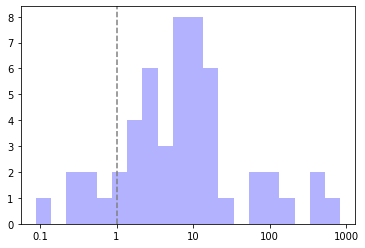

In [76]:
# plt.xscale("log")
plt.hist(np.log10(df_fin["M0 (mcmc)"].values/np.array(Mk_ls)),bins=20,color='b',alpha=0.3);
plt.xticks([-1,0,1,2,3], [0.1,1,10,100,1000])
plt.axvline(0,color='grey',ls='--')
plt.show()

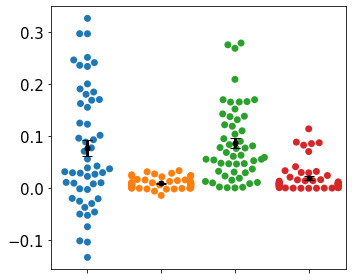

In [63]:
plt.figure(figsize=(5,4))
seed = 4
np.random.seed(seed)

var1 = df_fin["Rx (mcmc)"].values #Rx only
var2 = df_fin["Ry (mcmc)"].values
var3 = df_fin["M0 (mcmc)"].values
var4 = np.array(Mk_ls)

# hex_colors = ["#D8BFD8","#FF7256","#FFD700","#3CB371"]
# alphas = [0.6,0.6,0.6,1]
# rgb_colors = []
# for i in range(len(hex_colors)):
#     rgb_colors.append(alpha_to_rgb(hex_colors[i],alphas[i]))

sns.swarmplot(data=[var1,var2,var3,var4], size = 7)
plt.errorbar([0,1,2,3],[np.mean(var1),np.mean(var2),np.mean(var3),np.mean(var4)],\
             yerr = [np.std(var1)/np.sqrt(len(var1)),np.std(var2)/np.sqrt(len(var2)),\
                     np.std(var3)/np.sqrt(len(var3)),np.std(var4)/np.sqrt(len(var4))],\
             elinewidth = 3, fmt = '_', color = 'k', marker = '.', markersize = 10, \
             capsize = 5, capthick = 1, zorder = 10)

plt.xticks([0,1,2,3], ("","","",""),fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()
# plt.ylim(0.01,0.7)
# plt.gca().invert_yaxis()
